## Exploring Optopatch movies

Random ideas and vignettes. -MB

In [1]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('.')
sources_path = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.insert(0, sources_path)

import matplotlib.pylab as plt
import numpy as np
from time import time
import torch
import logging
import json

from cellmincer.opto_ws import OptopatchBaseWorkspace, OptopatchDenoisingWorkspace
from cellmincer.opto_utils import get_cosine_similarity_with_sequence_np

from sklearn.decomposition import TruncatedSVD, PCA

device = torch.device("cuda")
dtype = torch.float32

def new_fig(figsize=(30, 10)):
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    return fig, ax

logger = logging.getLogger()

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False

## Configuration

In [12]:
opto_mov_path_list = [
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/D1_FOV3_W2_at135105.npy',
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/D4_FOV2_W2_at171603.npy',
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/D4_FOV3_W2_at172029.npy',
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/E3_FOV1_W2_at155440.npy',
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/F1_FOV2_W1_at143005.npy']
transpose = True

# opto_mov_path_list = [
#     '/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_data/D1_FOV3_W2_at135105_denoised.npy',
#     '/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_data/D4_FOV2_W2_at171603_denoised.npy',
#     '/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_data/D4_FOV3_W2_at172029_denoised.npy',
#     '/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_data/E3_FOV1_W2_at155440_denoised.npy',
#     '/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_data/F1_FOV2_W1_at143005_denoised.npy']
# transpose = False

In [13]:
ws_base = OptopatchBaseWorkspace(
    opto_mov_path=opto_mov_path_list[4],
    transpose=transpose,
    logger=logger)

Loading movie from /home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/F1_FOV2_W1_at143005.npy ...


### Otsu on correlation mask

Calculating temporal correlation with neighbors ...
Calculating zero-mean movie ...
Calculating temporal mean ...
Calculating temporal std ...


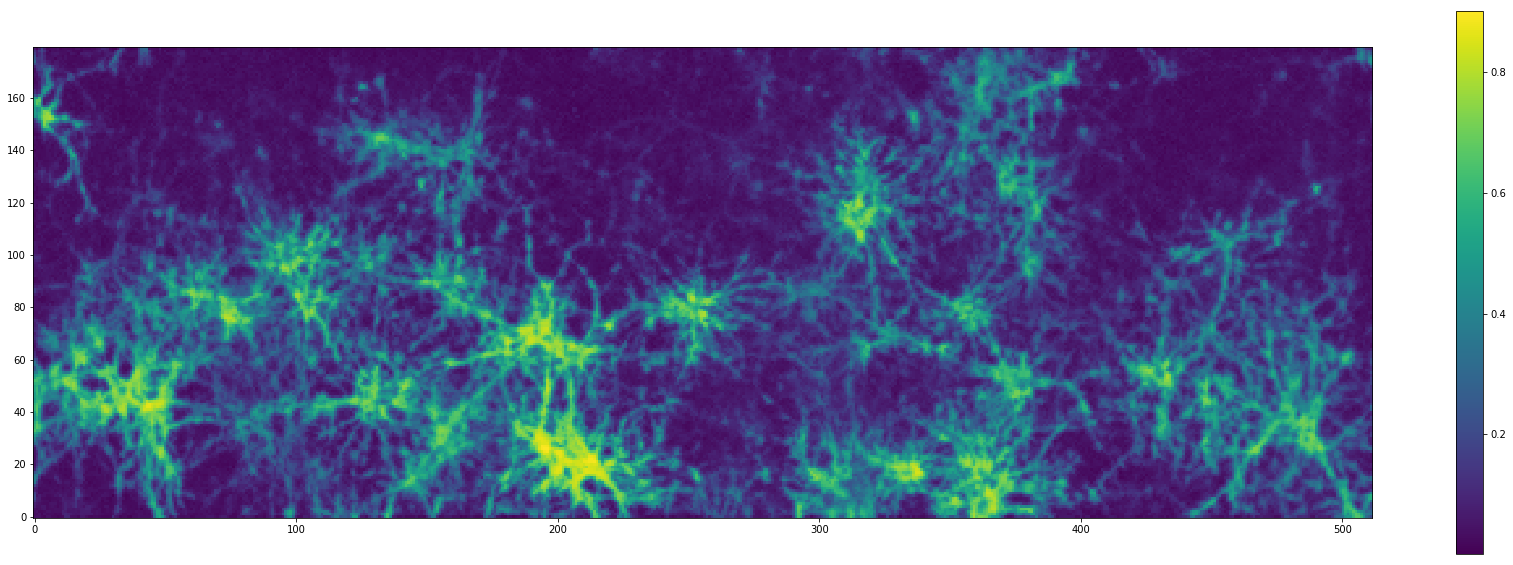

In [14]:
fig, ax = new_fig()
im = ax.imshow(ws_base.movie_t_corr_xy.T, origin='lower')
plt.colorbar(im)

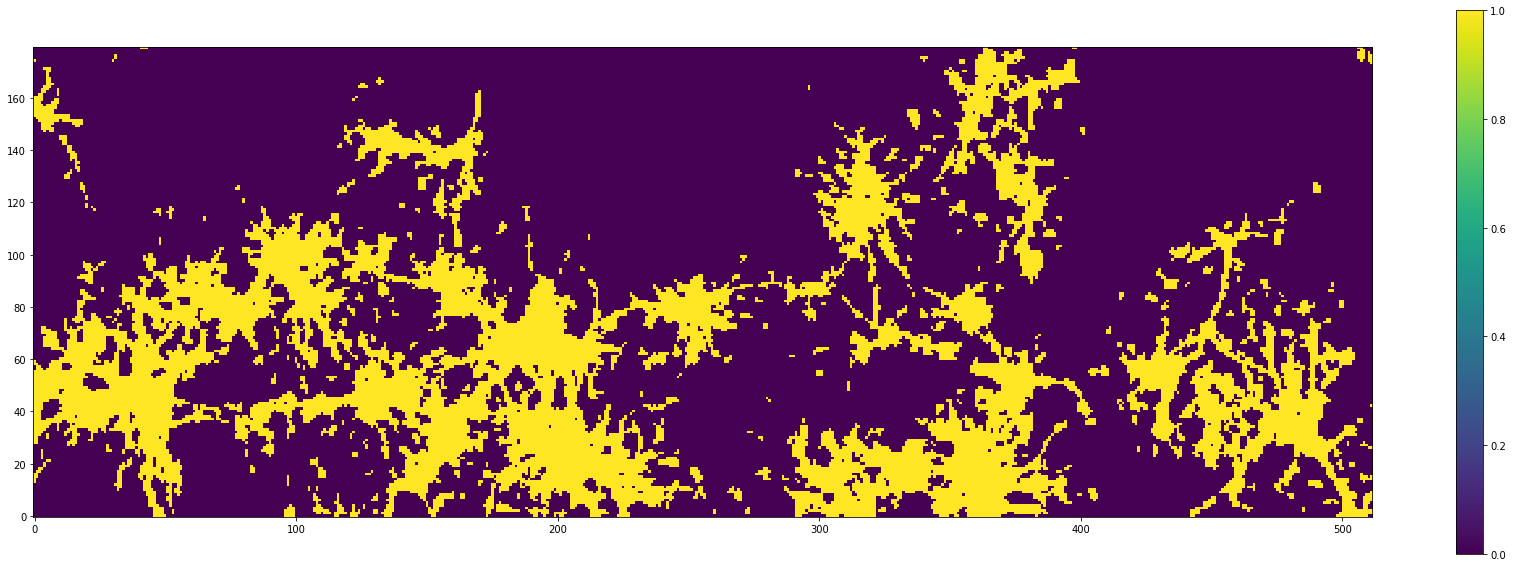

In [15]:
fig, ax = new_fig()
im = ax.imshow(ws_base.corr_otsu_fg_pixel_mask_xy.astype(np.float).T, origin='lower')
plt.colorbar(im)

### Otsu on cosine similarity map

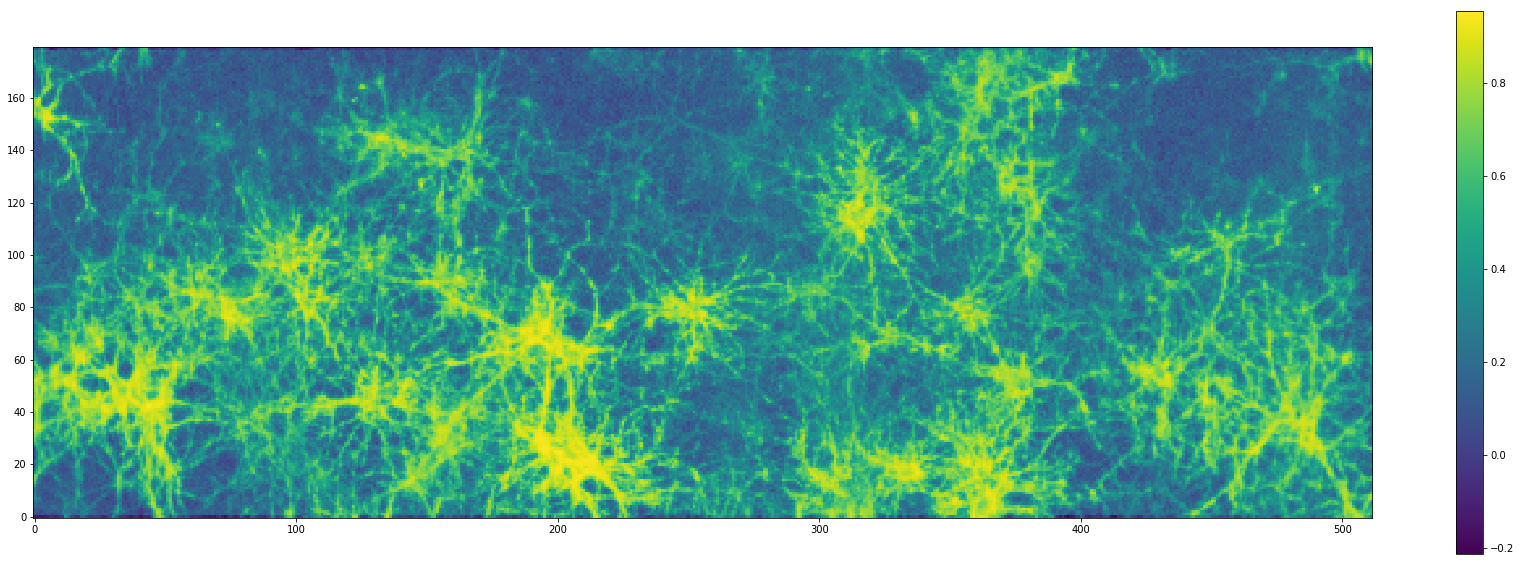

In [16]:
fig, ax = new_fig()
im = ax.imshow(ws_base.movie_cosine_fg_sim_xy.T, origin='lower')
plt.colorbar(im)

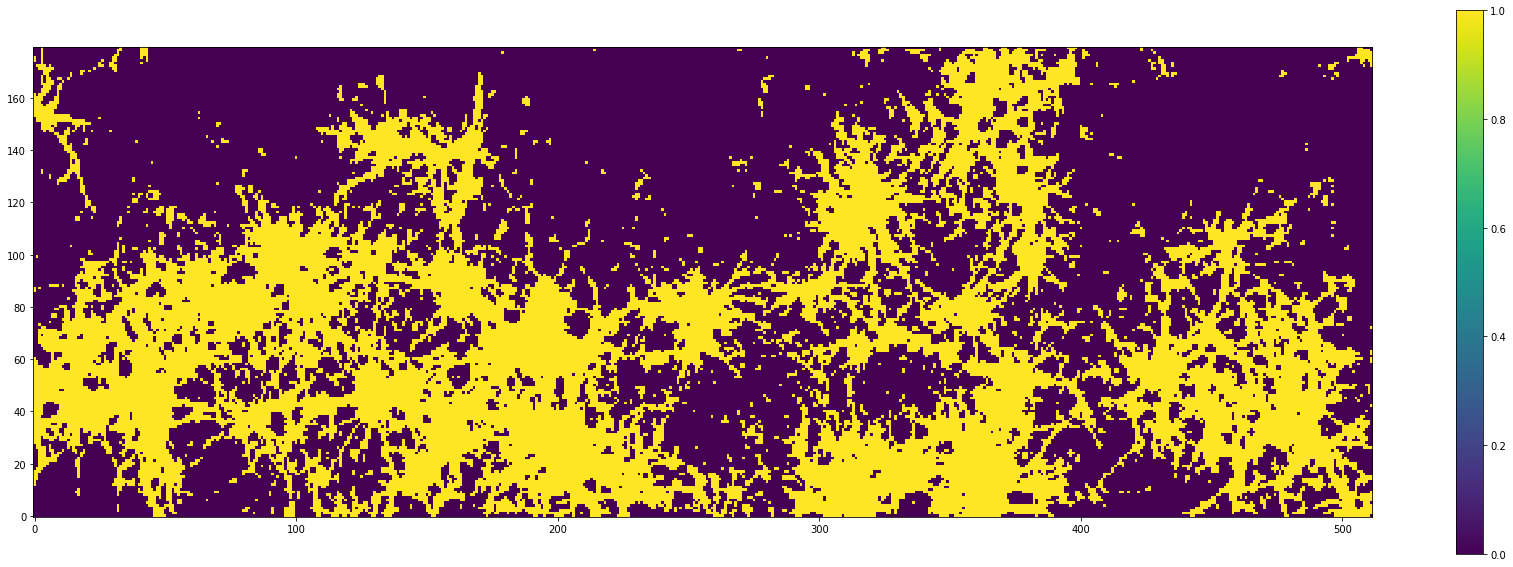

In [17]:
fig, ax = new_fig()
im = ax.imshow(ws_base.cosine_fg_sim_otsu_fg_pixel_mask_xy.astype(np.float).T, origin='lower')
plt.colorbar(im)

### Differential consine similarity between different neurons

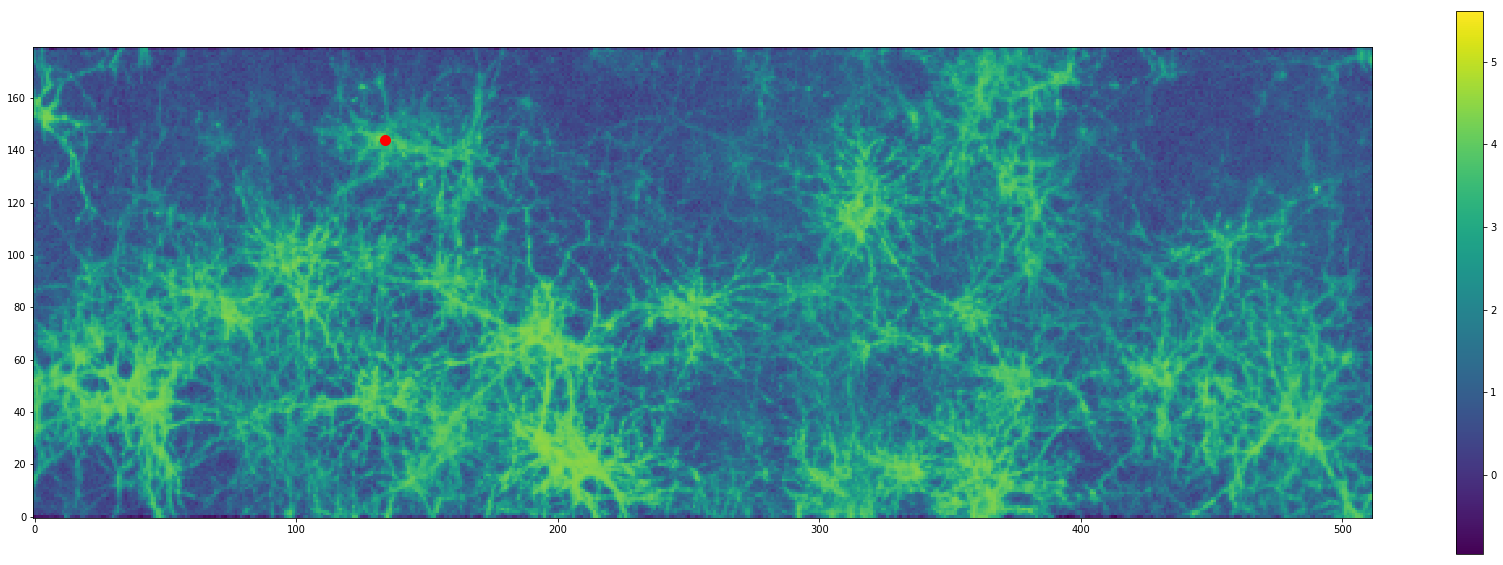

In [18]:
y = 144
x = 134

d_xy_1 = get_cosine_similarity_with_sequence_np(
    ws_base.movie_txy, ws_base.movie_txy[:, x, y])
d_xy_1 = d_xy_1 / np.std(d_xy_1)

fig, ax = new_fig()
im = ax.imshow(d_xy_1.transpose(), origin='lower')
plt.colorbar(im)
plt.plot(x, y, marker='.', markersize=20, color='red')

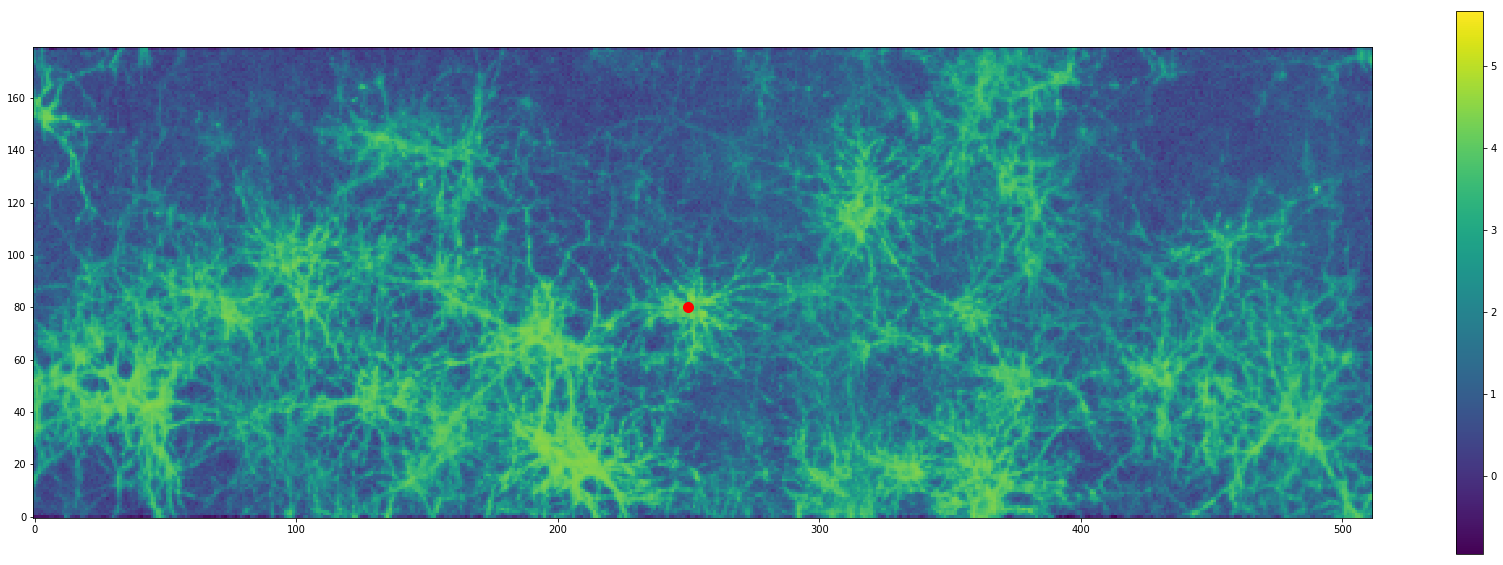

In [19]:
y = 80
x = 250

d_xy_2 = get_cosine_similarity_with_sequence_np(
    ws_base.movie_txy, ws_base.movie_txy[:, x, y])
d_xy_2 = d_xy_2 / np.std(d_xy_2)

fig, ax = new_fig()
im = ax.imshow(d_xy_2.transpose(), origin='lower')
plt.colorbar(im)
plt.plot(x, y, marker='.', markersize=20, color='red')

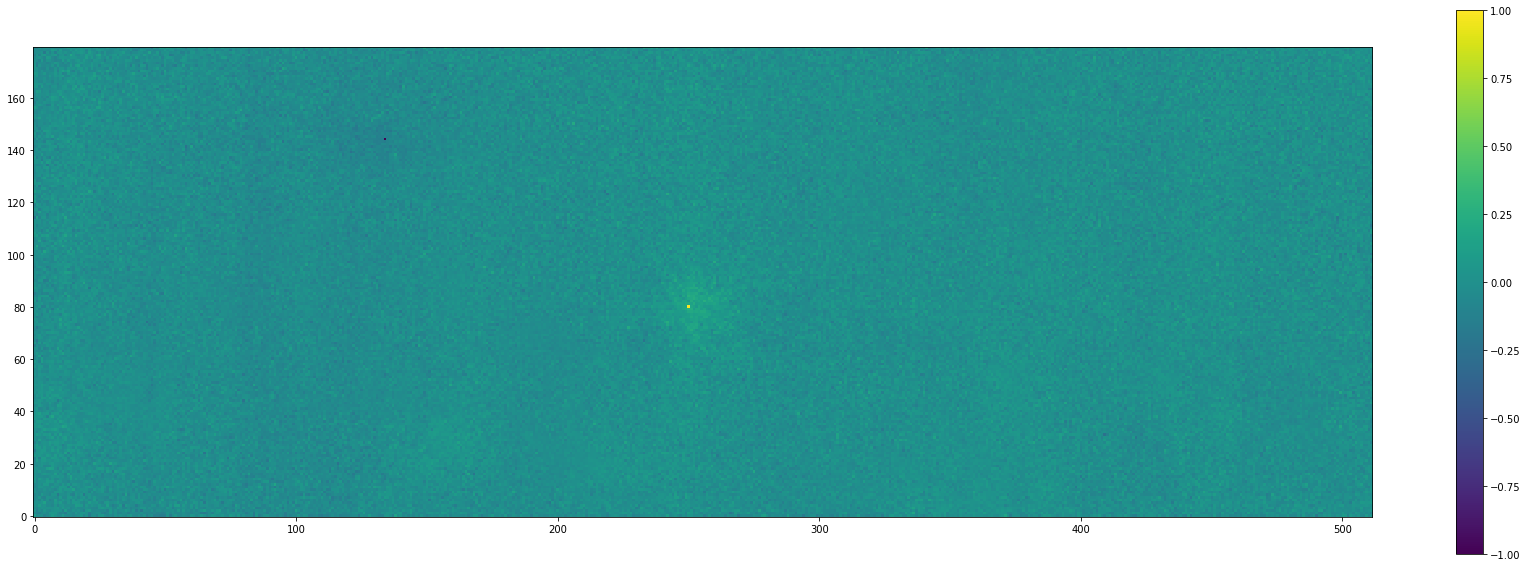

In [20]:
fig, ax = new_fig()
diff = d_xy_2 - d_xy_1
im = ax.imshow(diff.T, origin='lower', vmin=-1, vmax=1)
plt.colorbar(im)

### SVD denosing

In [22]:
movie_flat_tn = ws_base.movie_txy.reshape(ws_base.n_frames, -1).astype(np.float64)

In [23]:
max_components = 200
pca = PCA(n_components=max_components)
fit = pca.fit(movie_flat_tn)

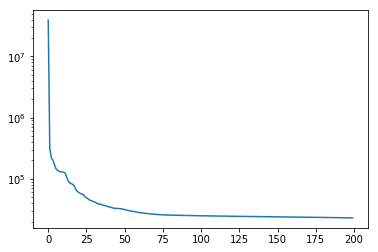

In [24]:
plt.plot(pca.explained_variance_)
plt.yscale('log')

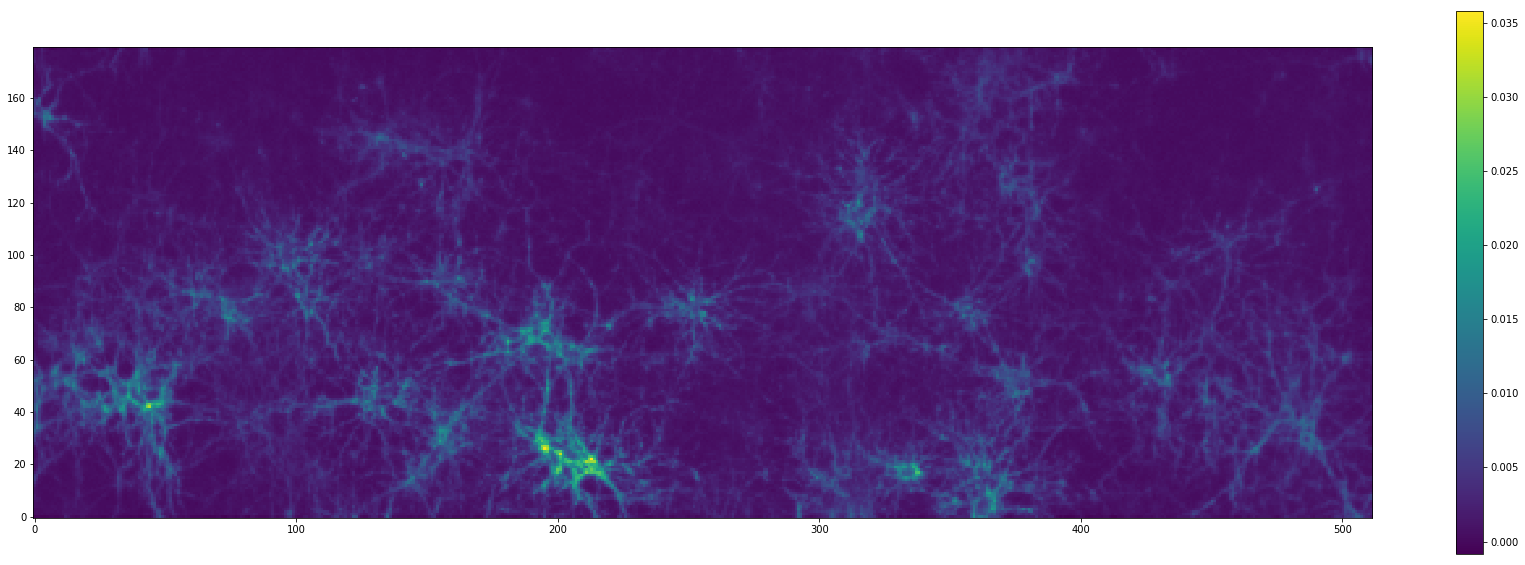

In [25]:
fig, ax = new_fig()
im = ax.imshow(fit.components_[0, :].reshape(ws_base.width, ws_base.height).T, origin='lower')
plt.colorbar(im)

In [26]:
movie_flat_trans_tk = fit.transform(movie_flat_tn)

In [27]:
# reconstruct
n_pca_recons = 100

recons_movie_flat_tn = np.matmul(
    movie_flat_trans_tk[:, :n_pca_recons], fit.components_[:n_pca_recons, :])

In [28]:
recons_movie_flat_txy = recons_movie_flat_tn.reshape(-1, ws_base.width, ws_base.height)

In [29]:
def get_average_trace(movie_txy, x0, y0, window):
    return np.mean(np.mean(movie_txy[:, (x0 - window):(x0 + window), :][:, :, (y0 - window):(y0 + window)], -1), -1)

Calculating zero-mean movie ...


(5000, 5500)

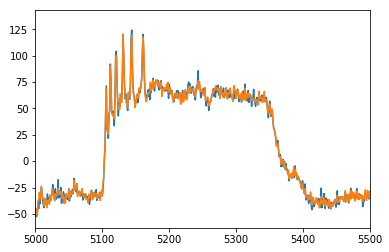

In [32]:
y0, x0, window = 80, 250, 6
plt.plot(get_average_trace(ws_base.movie_zero_mean_txy, x0, y0, window))
plt.plot(get_average_trace(recons_movie_flat_txy, x0, y0, window))
plt.xlim((5000, 5500))

Calculating zero-mean movie ...


(5000, 5500)

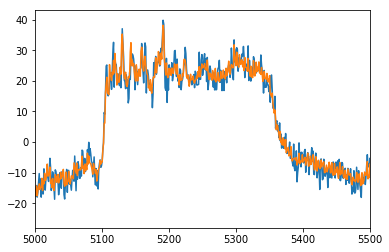

In [33]:
y0, x0, window = 70, 370, 6
plt.plot(get_average_trace(ws_base.movie_zero_mean_txy, x0, y0, window))
plt.plot(get_average_trace(recons_movie_flat_txy, x0, y0, window))
plt.xlim((5000, 5500))

Does not work very well -- even if we choose n_pcs in the tail of the explained-variance distribution, we loose some spikes.

In [2]:
# list of Optopatch movies
opto_mov_path_list = [
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/D1_FOV3_W2_at135105.npy',
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/D4_FOV2_W2_at171603.npy',
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/D4_FOV3_W2_at172029.npy',
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/E3_FOV1_W2_at155440.npy',
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/F1_FOV2_W1_at143005.npy'
]

# names
opto_mov_prefixes = [
    'D1_FOV3_W2_at135105',
    'D4_FOV2_W2_at171603',
    'D4_FOV3_W2_at172029',
    'E3_FOV1_W2_at155440',
    'F1_FOV2_W1_at143005'
]
    
output_path = '/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_data'


In [26]:
i_dataset = 0
model_prefix = 'rc1_t15_small_lr__unreg_'

denoised_movie_txy = np.load(
    os.path.join(
        output_path,
        opto_mov_prefixes[i_dataset] + "__" + model_prefix + "_denoised.npy"))

In [4]:
orig_movie_txy = np.load(opto_mov_path_list[i_dataset])

In [27]:
diff = np.power(np.abs(denoised_movie_txy - orig_movie_txy), 2).sum()

In [25]:
diff

715571460000.0

In [28]:
diff

715491100000.0